In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from obspy import UTCDateTime, read, Stream
from numpy import nanmean 

from andbro__readYaml import __readYaml
from andbro__savefig import __savefig
from andbro__querrySeismoData import __querrySeismoData
from andbro__convert_to_stream import __convert_to_stream

from functions.converstion_to_tilt import __conversion_to_tilt
from functions.load_tilt_sds import __load_tilt_sds


In [29]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
    archive_path = "/home/andbro/freenas/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

## Configurations

In [30]:
## configurations
config={}


## get downsampled data 
config['datapath'] = f"{data_path}TiltmeterDataBackup/Tilt_downsampled"

## time selection
config['tbeg'] = UTCDateTime("2022-04-24 00:00")
config['tend'] = UTCDateTime("2022-06-12 00:00")

## specify output directory for figures
config['output_figures'] = f"{root_path}Documents/ROMY/tiltmeter/figures/"

## indicate path to wromy data
config['path_to_wromy'] = f"{data_path}wromy/"

## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

## correction of offset (e.g. reset mass)
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")

## correction for temperature trends
## based on MAT
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")
## based on WSX
# temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","temperature_correction_new.yml")


## theoretical data

config['spotl_data'] = "/home/andbro/Documents/ROMY/SPOTL/spotl/working/ROMY/timeseries/"


## Load Data

In [31]:
def __load_local(config, seed_id):
    
    from tqdm.notebook import tqdm
    from obspy.clients.filesystem.sds import Client
    
    net, sta, loc, cha = seed_id.split(".")
    
    tbeg, tend = config['tbeg'], config['tend']

    st0 = Client(config['datapath'],fileborder_samples=1000).get_waveforms(net, sta, loc, cha, tbeg, tend)
    
    st0.merge()
    
    return st0

In [32]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [ ]:
TROMY0 = __load_tilt_sds(config, "BW.TROMY..MA*").sort()
print(TROMY0)
# TROMY0.plot(equal_scale=False);

In [8]:
ROMYT0 = __load_tilt_sds(config, "BW.ROMYT..MA*").sort()
print(ROMYT0)
# ROMYT0.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.ROMYT..MAE | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAN | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples
BW.ROMYT..MAT | 2022-04-24T00:09:59.940000Z - 2022-06-11T23:59:59.940000Z | 600.0 s, 7056 samples


3 Trace(s) in Stream:
BW.DROMY..LAE | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)
BW.DROMY..LAN | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)
BW.DROMY..LAT | 2022-04-24T00:00:00.000000Z - 2022-06-12T00:00:00.000000Z | 600.0 s, 7057 samples (masked)


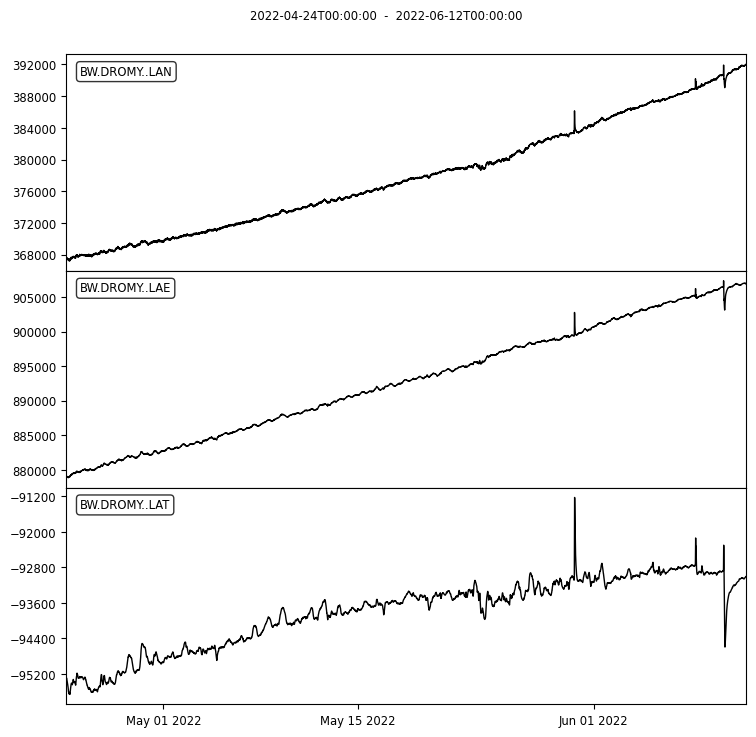

In [9]:
BROMY0 = __load_tilt_sds(config, "BW.DROMY..LA*").sort()
print(BROMY0)
BROMY0.plot(equal_scale=False);

In [711]:
TROMY = __conversion(TROMY0, confTilt['TROMY'])
ROMYT = __conversion(ROMYT0, confTilt['ROMYT'])
BROMY = __conversion(BROMY0, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


In [712]:
BROMY = BROMY.split().merge(fill_value="interpolate")

In [713]:
## Reset start to Zero
for st in [TROMY, ROMYT, BROMY]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

### Temperature Correction

In [714]:
def __correct_temperature_trend(st, correction, smooth=None):
    
    def __smooth(y, box_pts):
        from numpy import ones, convolve, hanning

        win = hanning(box_pts)
        y_smooth = convolve(y, win/sum(win), mode='same')

        return y_smooth    

    st0 = st.copy()
    
    if smooth:
        temperature = __smooth(st0.select(channel="*T")[0].data, smooth)
        temperature[:smooth] = temperature[smooth+1]
        temperature[-smooth:] = temperature[-smooth-1]
    else:
        temperature = st0.select(channel="*T")[0].data
        
#     st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
#     st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
    st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)
    
    return st0

In [715]:
## apply correction model
TROMY_T = __correct_temperature_trend(TROMY, temperature_correction['TROMY'], smooth=200)
ROMYT_T = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'])
BROMY_T = __correct_temperature_trend(BROMY, temperature_correction['BROMY'])

In [716]:
BROMY_T = BROMY_T.split().merge(fill_value="interpolate")

In [717]:
## Reset start to Zero
for st in [TROMY_T, ROMYT_T, BROMY_T]:
    for tr in st:
        if not tr.stats.channel[-1] == "T" or tr.stats.channel[0] == "W":
            tr.data -= tr.data[1]

### Load theoretical data

In [800]:
component = "ns" ## "ew" or "ns"

## tilts due to ocean loading in ???
spotl = pd.read_csv(config['spotl_data']+f"romy_{component}tilt_2022.out", header=1)
spotl

header = pd.read_csv(config['spotl_data']+f"romy_{component}tilt_2022.out", nrows=1)
header

## tilts due to Solid Earth Tides in (rad)
etides =  pd.read_csv(data_path+"tilts_theory.csv")
etides

## Ertid data
path = "/home/andbro/Documents/ROMY/SPOTL/spotl/"
ertid_ns = pd.read_csv(path+f"ertid_{component}_tilt.out", names=[f"{component}_tilt (nrad)"])
st_ertid_ns = __convert_to_stream(ertid_ns[f'{component}_tilt (nrad)'], starttime="2022-04-24 00:00", sampling_rate=1/(0.1*3600))
st_ertid_ns.resample(1/600)

1 Trace(s) in Stream:
XX.Test..ccc | 2022-04-24T00:00:00.000000Z - 2022-06-11T23:50:00.000000Z | 600.0 s, 7056 samples

In [801]:
st_etides_ns = __convert_to_stream(etides.tiltN, starttime="2022-04-24 00:00", sampling_rate=1/600, seed="BW.etide..LHN")
st_spotl_ns = __convert_to_stream(spotl.ns_tilt, starttime="2022-04-24 00:00", sampling_rate=1/600, seed="BW.spotl..LHN")

## Processing

In [806]:
TROMY_T_fil = TROMY_T.copy()


TROMY_T_fil.detrend("simple")

TROMY_T_fil.taper(0.01)

f_lower = 1/(2*86400)

TROMY_T_fil.filter("highpass", freq=f_lower, zerophase=True, corners=4)
# TROMY_T_fil.filter("bandpass", freqmin=f_lower, freqmax=1/(4*3600), zerophase=True, corners=4)

# TROMY_T_fil.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.TROMY..MAE | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAN | 2022-04-24T00:00:00.040000Z - 2022-06-11T23:50:00.040000Z | 600.0 s, 7056 samples
BW.TROMY..MAT | 2022-04-24T00:00:00.039999Z - 2022-06-11T23:50:00.039999Z | 600.0 s, 7056 samples

In [807]:
st_ertid_ns.filter("highpass", freq=f_lower, zerophase=True, corners=4);
st_spotl_ns.filter("highpass", freq=f_lower, zerophase=True, corners=4);

## Plotting

In [808]:
# st_etides_ns.plot();
# st_spotl_ns.plot();

No handles with labels found to put in legend.


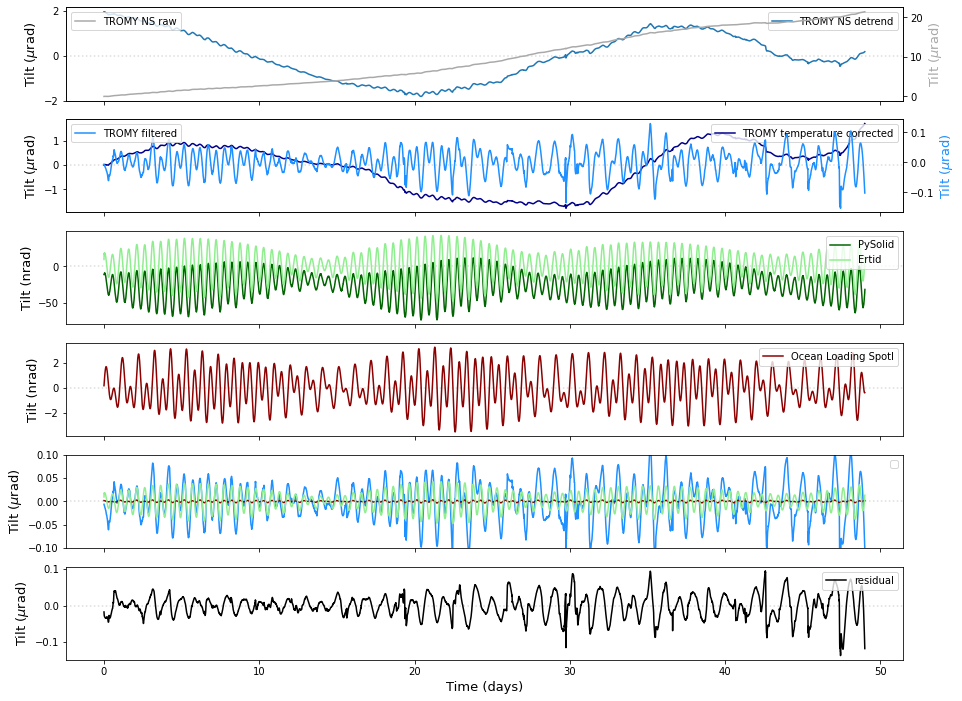

In [810]:
def __makeplot_overview():

    component = "N"
    
    shift = -21
    
    from numpy import roll
    
    NN = 6
    font = 13
    
    fig, ax = plt.subplots(NN, 1, figsize=(15,12), sharex=True)
    
    ref_t = UTCDateTime("2022-04-24 00:00")
    
    tilt_scaling, tilt_unit = 1e6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"

    ## panel 0 ------------------
    tromy_detrend = TROMY.copy().select(channel=f"*{component}")[0].detrend("linear").data*tilt_scaling
    
    ax[0].plot(TROMY.select(channel=f"*{component}")[0].times(reftime=ref_t)/time_scaling, 
               tromy_detrend,
               label="TROMY NS detrend"
              )
    ax0_2 = ax[0].twinx()
    ax0_2.plot(TROMY.select(channel=f"*{component}")[0].times(reftime=ref_t)/time_scaling, 
               TROMY.select(channel=f"*{component}")[0].data*tilt_scaling,
               color="darkgrey",
               label="TROMY NS raw"
              )
    ax0_2.legend(loc=2)
    
    ## panel 1 ------------------
    ax[1].plot(TROMY_T.select(channel=f"*{component}")[0].times(reftime=ref_t)/time_scaling,
               TROMY_T.select(channel=f"*{component}")[0].data*tilt_scaling,
               label="TROMY temperature corrected",
               color="darkblue"
              )

    ax1_2 = ax[1].twinx()
    ax1_2.plot(TROMY_T_fil.select(channel=f"*{component}")[0].times(reftime=ref_t)/time_scaling,
               TROMY_T_fil.select(channel=f"*{component}")[0].data*tilt_scaling,
               label="TROMY filtered",
               color="dodgerblue"
              )
    ax1_2.legend(loc=2)
    
    ## panel 2 ------------------    
    ax[2].plot(st_etides_ns[0].times(reftime=ref_t)/time_scaling,
               st_etides_ns[0].data*1e9,
               label="PySolid",
               color="darkgreen"
              )
    ax[2].plot(st_ertid_ns[0].times(reftime=ref_t)/time_scaling,
               st_ertid_ns[0].data,
               label="Ertid",
               color="lightgreen"
              )

    ## panel 3 ------------------    
    ax[3].plot(st_spotl_ns[0].times(reftime=ref_t)/time_scaling,
               st_spotl_ns[0].data,
               label="Ocean Loading Spotl",
               color="darkred",
              )

    ## panel 4 ------------------    
    tromy_ns = TROMY_T_fil.select(channel=f"*{component}")[0].data*tilt_scaling
    spotl_ns = roll(st_spotl_ns[0].data*1e-3, shift)
    
    
    ax[4].plot(TROMY.select(channel=f"*{component}")[0].times(reftime=ref_t)/time_scaling, 
               TROMY_T_fil.select(channel=f"*{component}")[0].data*tilt_scaling,
               color="dodgerblue"
              )    
    ax[4].plot(TROMY.select(channel=f"*{component}")[0].times(reftime=ref_t)/time_scaling,
               spotl_ns,
               color="darkred"
              )      
    ax[4].plot(st_ertid_ns[0].times(reftime=ref_t)/time_scaling,
               st_ertid_ns[0].data*1e-3,
               color="lightgreen"
              )     
    ax[4].set_ylim(-0.1, 0.1)

    ## panel 5 ------------------    
    
    res_tromy_ns = tromy_ns - spotl_ns - st_ertid_ns[0].data*1e-3
    
    ax[5].plot(st_spotl_ns[0].times(reftime=ref_t)/time_scaling,
               res_tromy_ns,
               label="residual",
               color="black"
              )  
    
    
    
    for i in range(NN):
        ax[i].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
        ax[i].axhline(0, zorder=-1, ls=":", color="darkgrey", alpha=0.4)
        ax[i].legend(loc=1)

    ax[2].set_ylabel("Tilt (nrad)", fontsize=font)
    ax[3].set_ylabel("Tilt (nrad)", fontsize=font)
    
    ax0_2.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="darkgrey")
    ax1_2.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font, color="dodgerblue")

    
    ax[NN-1].set_xlabel(f"Time ({time_unit})", fontsize=font)

    plt.show()

__makeplot_overview()

NameError: name 'np' is not defined

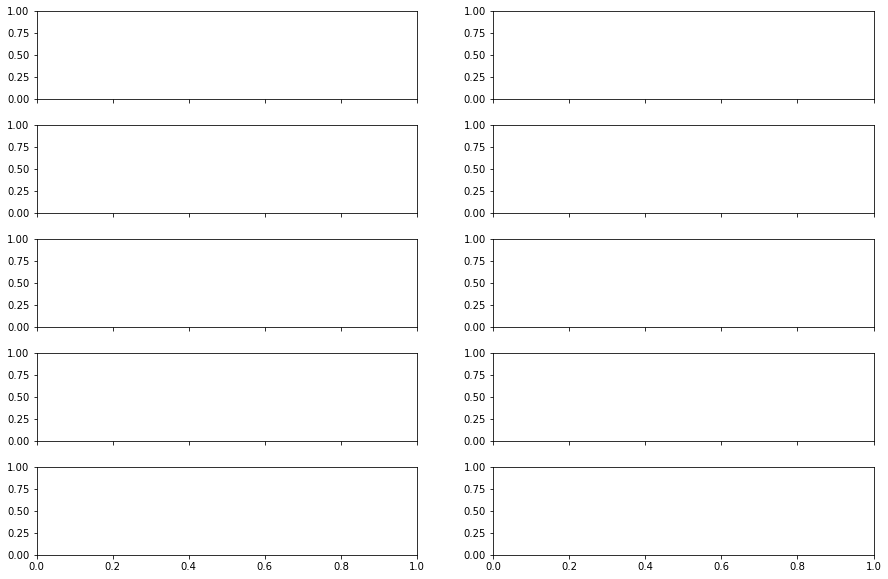

In [828]:
component = "N"
tilt_scaling = 1e6

tromy_ns = TROMY_T_fil.select(channel=f"*{component}")[0].data*tilt_scaling
spotl_ns = st_spotl_ns[0].data*1e-3
ertid_ns = st_ertid_ns[0].data*1e-3

res_tromy_ns = tromy_ns - spotl_ns - ertid_ns

st_res = __convert_to_stream(res_tromy_ns)

__makeplotStreamSpectra(st_res, config)



In [780]:
# from andbro__crosscorrelation import __crosscorrelation

# tromy_ns = TROMY_T_fil.select(channel="MAN")[0].taper(0.01).data*1e6
# spotl_ns = st_spotl_ns[0].taper(0.01).data*2e-2


# __crosscorrelation(tromy_ns, spotl_ns, deltaT=600)

In [729]:
# BROMY_T_fil = BROMY.copy()


# BROMY_T_fil.detrend("simple")

# BROMY_T_fil.taper(0.01)

# # BROMY_T_fil.filter("highpass", freq=1/(5*86400), zerophase=True, corners=4)
# BROMY_T_fil.filter("bandpass", freqmin=1/(5*86400), freqmax=1/(2*3600), zerophase=True, corners=4)

# # BROMY_T_fil.plot(equal_scale=False);

In [730]:
# def __makeplot_overview():
    
#     NN = 6
#     font = 13
    
#     fig, ax = plt.subplots(NN, 1, figsize=(15,12), sharex=True)
    
#     ref_t = UTCDateTime("2022-04-24 00:00")
    
#     tilt_scaling, tilt_unit = 1e6, r"$\mu$rad"
#     time_scaling, time_unit = 86400, "days"

#     ## panel 0 ------------------
#     tromy_detrend = BROMY.copy().select(channel="*N")[0].detrend("linear").data*tilt_scaling
    
#     ax[0].plot(BROMY.select(channel="*N")[0].times(reftime=ref_t)/time_scaling, 
#                tromy_detrend,
#                label="TROMY NS detrend"
#               )
#     ax0_2 = ax[0].twinx()
#     ax0_2.plot(BROMY.select(channel="*N")[0].times(reftime=ref_t)/time_scaling, 
#                BROMY.select(channel="*N")[0].data*tilt_scaling,
#                color="darkgrey",
#                label="TROMY NS raw"
#               )
#     ax0_2.legend()
    
#     ## panel 1 ------------------
#     ax[1].plot(BROMY_T.select(channel="*N")[0].times(reftime=ref_t)/time_scaling,
#                BROMY_T.select(channel="*N")[0].data*tilt_scaling,
#                label="TROMY Tcorrect",
#               )

#     ax1_2 = ax[1].twinx()
#     ax1_2.plot(BROMY_T_fil.select(channel="*N")[0].times(reftime=ref_t)/time_scaling,
#                BROMY_T_fil.select(channel="*N")[0].data*tilt_scaling,
#                label="TROMY filtered",
#                color="grey"
#               )
#     ax1_2.legend(loc=2)

#     ## panel 2 ------------------    
#     ax[2].plot(st_etides_ns[0].times(reftime=ref_t)/time_scaling,
#                st_etides_ns[0].data*1e9,
#                label="PySolid",
#                color="darkgreen"
#               )
#     ax[2].plot(st_ertid_ns[0].times(reftime=ref_t)/time_scaling,
#                st_ertid_ns[0].data,
#                label="Ertid",
#                color="lightgreen"
#               )
    
    
#     ## panel 3 ------------------    
#     ax[3].plot(st_spotl_ns[0].times(reftime=ref_t)/time_scaling,
#                st_spotl_ns[0].data,
#                label="Ocean Loading Spotl",
#                color="darkred",
#               )

#     ## panel 4 ------------------    
#     bromy_ns = BROMY_T_fil.select(channel="*N")[0].data*tilt_scaling
    
#     res_Bromy_ns = bromy_ns - st_spotl_ns[0].data[:-1]*1e-6
    
#     ax[4].plot(BROMY.select(channel="*N")[0].times(reftime=ref_t)/time_scaling, 
#                BROMY_T_fil.select(channel="*N")[0].data*tilt_scaling
#               )    
# #     ax[4].plot(st_spotl_ns[0].times(reftime=ref_t)/time_scaling,
# #                st_spotl_ns[0].data*3e-2
# #               )      

#     ax[4].set_ylim(-.2,.2)
    
# #     res_Bromy_ns = bromy_ns - st_spotl_ns[0].data*2e-2 - st_etides_ns[0].data[:-1]*1e6
    
# #     ax[5].plot(st_spotl_ns[0].times(reftime=ref_t)/time_scaling,
# #                res_bromy_ns
# #               )    
#     ax[5].plot(st_ertid_ns[0].times(reftime=ref_t)/time_scaling,
#                st_ertid_ns[0].data,
#                )
    
    
#     for i in range(NN):
#         ax[i].set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
#         ax[i].legend(loc=1)
    
#     ax0_2.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)
#     ax1_2.set_ylabel(f"Tilt ({tilt_unit})", fontsize=font)

    
#     ax[NN-1].set_xlabel(f"Time ({time_unit})", fontsize=font)

#     plt.show()

    
# __makeplot_overview()